<a href="https://colab.research.google.com/github/vitalivu/short-sentences-similarity/blob/master/Vietnamese_sentence_embeddings_PhoBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tóm tắt

Dựa trên bài báo [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/abs/1908.10084). Áp dụng để tính toán mức độ tương tự về ngữ nghĩa của câu trong Tiếng Việt.


# Các thư viện được sử dụng

- https://huggingface.co/vinai/phobert-base
- https://github.com/vitalivu/underthesea
- https://www.sbert.net/

# Tham khảo

Bibfile
```
@inproceedings{sbert2019,
  title = "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks",
  author = "Reimers, Nils and Gurevych, Iryna",
  booktitle = "Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing",
  month = "11",
  year = "2019",
  publisher = "Association for Computational Linguistics",
  url = "https://arxiv.org/abs/1908.10084",
}
@article{phobert2020,
  title     = {{PhoBERT: Pre-trained language models for Vietnamese}},
  author    = {Dat Quoc Nguyen and Anh Tuan Nguyen},
  journal   = {Findings of EMNLP},
  year      = {2020}
}
```

# Cài đặt các thư viện


In [ ]:
!pip install transformers
!pip install sentence-transformers
!pip install git+https://github.com/vitalivu/underthesea.git #original source code has version conflict issue

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as f

from underthesea import word_tokenize
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = phobert.eval().to(device)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


PhoBERT yêu cầu các câu đầu vào sử dụng các từ đã được phân đoạn (segmented). Sử dụng underthesea library để làm việc này.

In [3]:
texts = ['Vùng có thu nhập bình quân đầu người cao nhất cả nước là Đông Nam Bộ',
    'Bình Dương là địa phương có thu nhập bình quân đầu người cao nhất,', 
    'Angela sinh ra trong một gia đình đông con và không khá giả']

texts = [word_tokenize(text, format="text") for text in texts]

for text in texts:
    print(len(text.split(" ")), text)

12 Vùng có thu_nhập bình_quân đầu người cao nhất cả nước là Đông_Nam_Bộ
11 Bình_Dương là địa_phương có thu_nhập bình_quân đầu người cao nhất ,
11 Angela sinh ra trong một gia_đình đông con và không khá_giả


Bổ sung thêm `padding=True` để thêm padding vào các câu ngắn, đảm bảo các câu có độ dài giống với nhau. Như ví dụ ở trên thì câu dài nhất (câu 1) có 12 từ, nên hai câu sau sẽ thêm 1 pad.



In [4]:
encodings = tokenizer(texts, padding=True,
    return_tensors='pt' # return the tensors (not lists)
)
encodings = encodings.to(device)
encodings

{'input_ids': tensor([[    0,  4805,    10,  1067,  2350,   127,    18,    84,    67,    94,
            58,     8, 22115,     2],
        [    0,  1952,     8,   296,    10,  1067,  2350,   127,    18,    84,
            67,     4,     2,     1],
        [    0, 43745,   418,    40,    12,    16,   161,   553,    73,     6,
            17, 10883,     2,     1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])}

Tensor output có các dữ liệu sau:
- **`input_ids`** list các `token id` của mỗi câu, sử dụng tokenizer để convert ngược lại ra từ ban đầu. Các `token id` dặc biệt ở đây có:
  - `0` là id của token bắt đầu một câu: `<s>`
  - `1` đại diện cho token kết thúc câu: `</s>`
  - `2` đại diện cho token pad: `<pad>`
- **`attention_mask`**: thể hiện id nào dùng để tạo ra token, các token `<pad>` sẽ bị bỏ qua
- **`token_type_ids`**: thể hiện token tương ứng với



In [5]:
encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [6]:
encodings['input_ids']

tensor([[    0,  4805,    10,  1067,  2350,   127,    18,    84,    67,    94,
            58,     8, 22115,     2],
        [    0,  1952,     8,   296,    10,  1067,  2350,   127,    18,    84,
            67,     4,     2,     1],
        [    0, 43745,   418,    40,    12,    16,   161,   553,    73,     6,
            17, 10883,     2,     1]])

In [7]:
encodings['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]])

In [8]:
encodings['token_type_ids']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Sử dụng tokenizer để chuyển đội token id về token như sau

In [9]:
for ids in encodings['input_ids']:
    print(tokenizer.convert_ids_to_tokens(ids))

['<s>', 'Vùng', 'có', 'thu_nhập', 'bình_quân', 'đầu', 'người', 'cao', 'nhất', 'cả', 'nước', 'là', 'Đông_Nam_Bộ', '</s>']
['<s>', 'Bình_Dương', 'là', 'địa_phương', 'có', 'thu_nhập', 'bình_quân', 'đầu', 'người', 'cao', 'nhất', ',', '</s>', '<pad>']
['<s>', 'Angela', 'sinh', 'ra', 'trong', 'một', 'gia_đình', 'đông', 'con', 'và', 'không', 'khá_giả', '</s>', '<pad>']


# Câu nhúng

Để tính được token embeddings chúng ta gửi encoding qua model. Pytorch thực hiện tính gradient cho mỗi layer trong model - việc này chỉ hữu ích với quá trình huấn luyện model nên chúng ta có thể bỏ qua. 

Việc bỏ qua gradient (`.no_grad`) cũng giúp tiết kiệm được không gian nhớ trên CPU/GPU.

In [10]:
with torch.no_grad():
    embeds = model(**encodings)
embeds = embeds[0]

In [11]:
def visualize(distances, figsize=(10, 5), titles=None):
    """
    
    """
    ncols = len(distances)
    fig, ax = plt.subplots(ncols=ncols, figsize=figsize)
    
    for i in range(ncols):
        axes = ax[i] if ncols > 1 else ax
        distance = distances[i]
        axes.imshow(distance)
        axes.set_xticks(np.arange(distance.shape[0]))
        axes.set_yticks(np.arange(distance.shape[1]))
        axes.set_xticklabels(np.arange(distance.shape[0]))
        axes.set_yticklabels(np.arange(distance.shape[1]))

        for j in range(distance.shape[0]): # index of sentences in array
            for k in range(distance.shape[1]):
                text = axes.text(k, j, str(round(distance[j, k], 3)), ha="center", va="center", color="w")
                
        title = titles[i] if titles and len(titles) > i else "Text Distance"
        axes.set_title(title, fontsize="x-large")
        
    fig.tight_layout()
    plt.show()

# Độ tương tự
Tính khoảng cách giữa các vector embeddings để so sánh độ tương tự. Thực hiện ba phương pháp:
- dùng `[CLS]` token
- `MEAN` của tất cả các token
- `MAX` của tất cả các token trong câu.

1. Sử dụng `[CLS]` tokens - lấy embeddings của `[CLS]` token

In [12]:
CLSs = embeds[:, 0, :]
normalized = f.normalize(CLSs, p=2, dim=1)
cls_dist = normalized.matmul(normalized.T)
cls_dist = cls_dist.new_ones(cls_dist.shape) - cls_dist
cls_dist = cls_dist.numpy()

2. `MEANS` tokens

In [13]:
MEANS = embeds.mean(dim=1)
normalized = f.normalize(MEANS, p=2, dim=1)
mean_dist = normalized.matmul(normalized.T)
mean_dist = mean_dist.new_ones(mean_dist.shape) - mean_dist
mean_dist = mean_dist.numpy()

3. `MAX` over time

In [14]:
MAXS, _ = embeds.max(dim=1)
normalized = f.normalize(MAXS, p=2, dim=1)
max_dist = normalized.matmul(normalized.T)
max_dist = max_dist.new_ones(max_dist.shape) - max_dist
max_dist = max_dist.numpy()

# So sánh kết quả


In [15]:
texts

['Vùng có thu_nhập bình_quân đầu người cao nhất cả nước là Đông_Nam_Bộ',
 'Bình_Dương là địa_phương có thu_nhập bình_quân đầu người cao nhất ,',
 'Angela sinh ra trong một gia_đình đông con và không khá_giả']

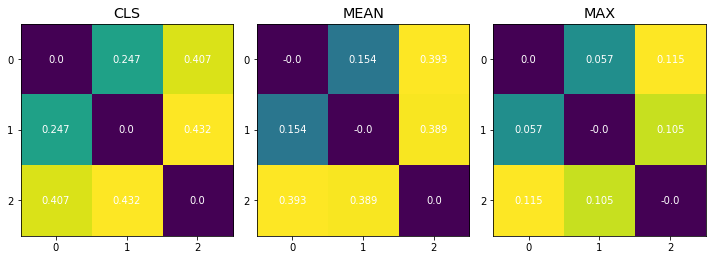

In [16]:
dist = [cls_dist, mean_dist, max_dist]
titles = ["CLS", "MEAN", "MAX"]
visualize(dist, titles=titles)

Từ biểu diễn trên, nhận xét: đối với cả ba phương pháp, 
- câu 0 và câu 1 gần nhau hơn là câu 2, rõ nhất ở MAX (MAX < MEAN < CLS) => mức độ tương tự cao hơn
- khoảng cách từ câu 2 đến câu 1 và câu 0 là tương đồng với nhau ở MEAN (MEAN < MAX < CLS)

Như vậy có thể kết quả này khác với công bố SBERT!!!

# TODO

- tìm dataset tiếng Việt tương tự Standford NLI và Multi-Genre NLI
- thực nghiệm để so sánh kết quả